In [2]:
import sympy
from sympy.abc import *
from sympy import Matrix
from sympy.discrete.transforms import fft
from sympy.matrices.expressions.fourier import DFT
from sympy import convolution

c = Matrix([[2, 1, 3]]).transpose()
d = Matrix([[3, 1, 2]]).transpose()
cd = Matrix([convolution(c, d, cycle=3)]).transpose()

F3 = DFT(3).as_explicit() * sympy.sqrt(3)

# Convolution rules
fc = F3 * c
fd = F3 * d
fcd = F3 * cd
display(fc)
display(fd)
fcd_1 = fc.multiply_elementwise(fd)
display(fcd_1)
display(fcd)

Matrix([
[                                   6],
[2 + exp(-2*I*pi/3) + 3*exp(2*I*pi/3)],
[2 + 3*exp(-2*I*pi/3) + exp(2*I*pi/3)]])

Matrix([
[                                   6],
[3 + exp(-2*I*pi/3) + 2*exp(2*I*pi/3)],
[3 + 2*exp(-2*I*pi/3) + exp(2*I*pi/3)]])

Matrix([
[                                                                           36],
[(2 + exp(-2*I*pi/3) + 3*exp(2*I*pi/3))*(3 + exp(-2*I*pi/3) + 2*exp(2*I*pi/3))],
[(2 + 3*exp(-2*I*pi/3) + exp(2*I*pi/3))*(3 + 2*exp(-2*I*pi/3) + exp(2*I*pi/3))]])

Matrix([
[                                       36],
[11 + 11*exp(-2*I*pi/3) + 14*exp(2*I*pi/3)],
[11 + 14*exp(-2*I*pi/3) + 11*exp(2*I*pi/3)]])

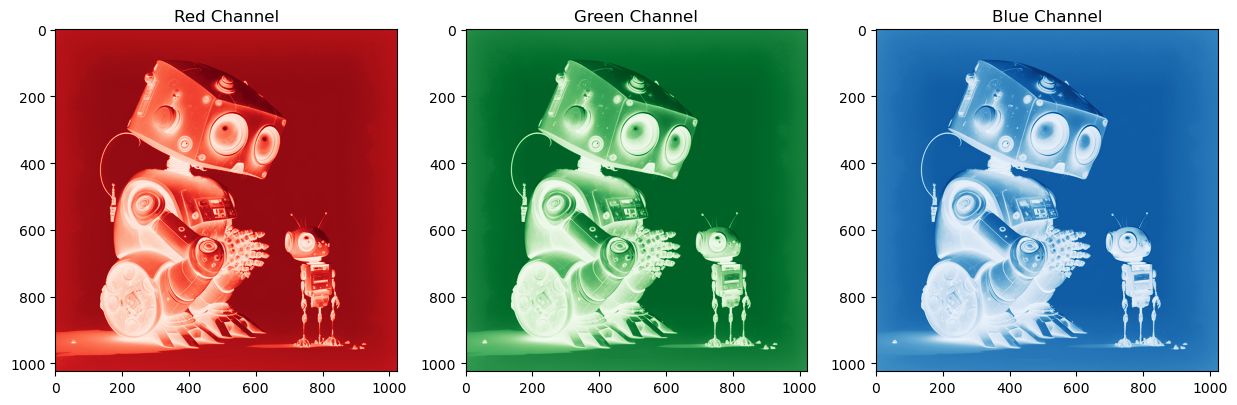

In [3]:
# Example: gaussian Blur
import numpy as np
import matplotlib.pyplot as plt

# Load image as 2D matrix
img = plt.imread('bot.png')
# Separate RGB channels
red_channel = img[:, :, 0]
green_channel = img[:, :, 1]
blue_channel = img[:, :, 2]

# Display each channel separately
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 10))
ax1.imshow(red_channel, cmap='Reds')
ax1.set_title('Red Channel')
ax2.imshow(green_channel, cmap='Greens')
ax2.set_title('Green Channel')
ax3.imshow(blue_channel, cmap='Blues')
ax3.set_title('Blue Channel')
plt.show()

In [4]:
g5 = np.array([1, 4, 7, 4, 1])
gm5 = np.outer(g5, g5)
gk5 = gm5 / np.sum(gm5)

g3 = np.array([1, 4, 1])
gm3 = np.outer(g3, g3)
gk3 = gm3 / np.sum(gm3)

# test_img = np.random.randn(11, 11, 4)
test_img = np.zeros((11, 11, 4), dtype=np.float32)
test_img[0, 0, :] = [1.0, 0, 0, 1.0]
test_img[0, 1, :] = [1.0, 0, 0, 1.0]
test_img[1, 0, :] = [1.0, 0, 0, 1.0]
test_img[1, 1, :] = [1.0, 0, 0, 1.0]
test_img[0, 10, :] = [0.0, 1.0, 0, 1.0]
test_img[10, 0, :] = [0.0, 0, 1.0, 1.0]
test_img[10, 10, :] = [0.0, 0.0, 0.0, 1.0]

def naive_conv(img, kernel):
    M, N, K = img.shape[0], img.shape[1], img.shape[2]
    E = kernel.shape[0]
    result = np.zeros_like(img)
    for i in range(M - E + 1):
        for j in range(N - E + 1):
            for k in range(K):
                linear = img[i:i+E, j:j+E, k] * kernel
                if np.isnan(linear).any(): raise
                result[i][j][k] = linear.sum()
    return result

# blurred = naive_conv(img, gaussian_kernel)
test_blurred = naive_conv(test_img, gk3)

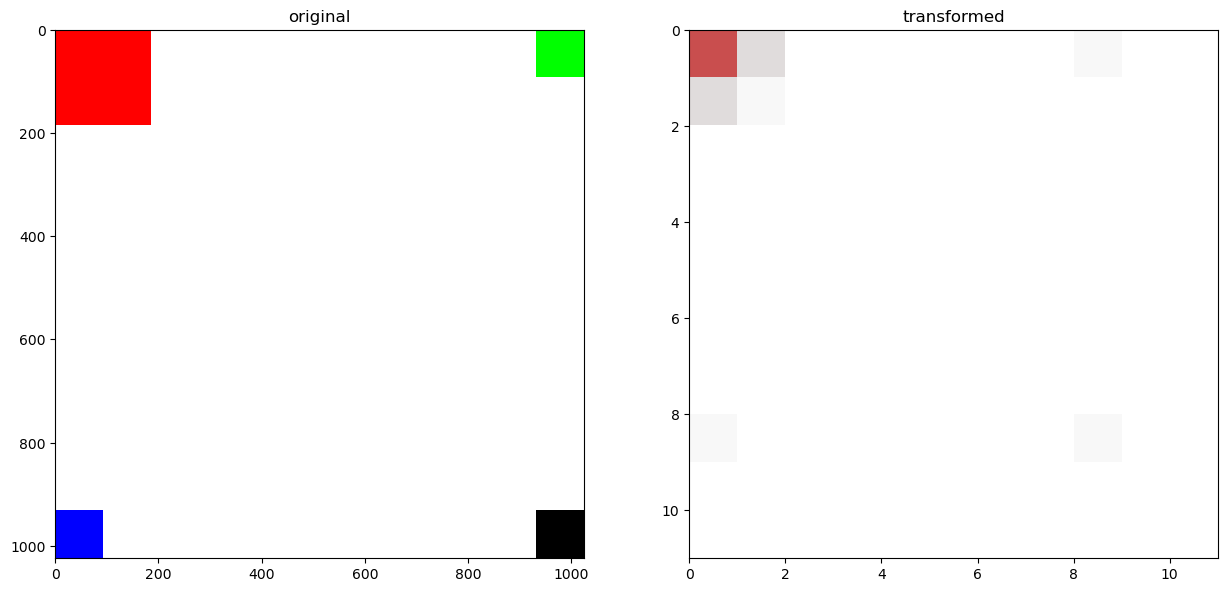

In [5]:
# without padding, dimensions are reduced
def conv_and_plot(img, kernel, conv_fn, figsize=(15, 10)):
    transform_and_plot(img, lambda img: conv_fn(img, kernel), figsize)

def transform_and_plot(img, fn, figsize=(15, 10)):
    transformed = fn(img)
    plot_transformed(img, fn(img), figsize=(15, 10))

def plot_transformed(origin, transformed, figsize=(15, 10)):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=figsize)
    ax1.set_title("original")
    ax1.imshow(origin, extent=[0, img.shape[1], img.shape[0], 0])

    ax2.set_title(f"transformed")
    ax2.imshow(transformed, extent=[0, transformed.shape[1], transformed.shape[0], 0])
    plt.show()

conv_and_plot(test_img, gk3, conv_fn=naive_conv)

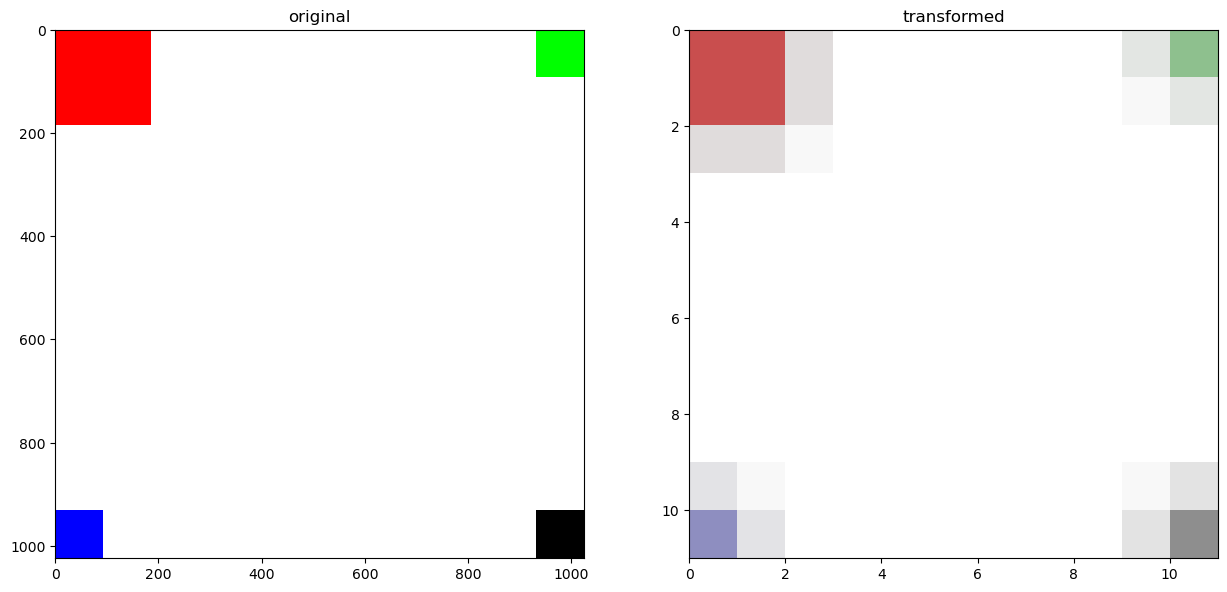

In [6]:
def pad_conv(img, kernel):
    M, N, K = img.shape[0], img.shape[1], img.shape[2]
    E = kernel.shape[0]
    P = (E - 1) // 2
    result = np.empty_like(img)
    img = np.pad(img, ((P, P), (P, P), (0, 0)), 'constant')
    for i in range(M):
        for j in range(N):
            for k in range(K):
                linear = img[i:i+E, j:j+E, k] * kernel
                result[i][j][k] = linear.sum()
    return result

# Adding padding fix the dimension reduction issue
conv_and_plot(test_img, gk3, conv_fn=pad_conv)

In [7]:
# But the naive convolution is O(MNK*E), how could we do better?

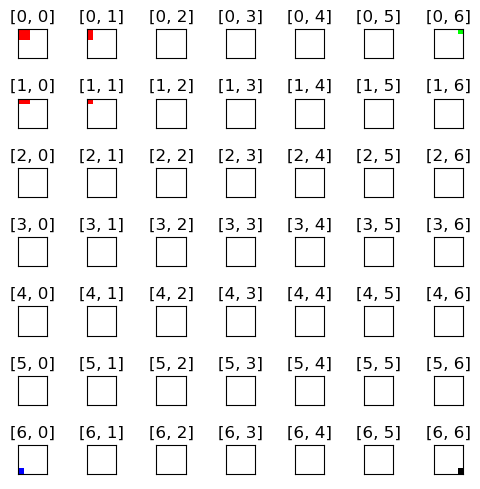

In [8]:
def display_sliding_window(img, kernel):
    M, N = img.shape[0], img.shape[1]
    window_shape = kernel.shape + (4,)
    nrows=M - kernel.shape[0] + 1
    ncols=N - kernel.shape[1] + 1
    window = np.lib.stride_tricks.sliding_window_view(img, window_shape).squeeze(axis=len(window_shape) - 1)
    fig, axs = plt.subplots(nrows, ncols, figsize=(kernel.shape[0], kernel.shape[1]))

    for i in range(nrows):
        for j in range(ncols):
            axs[i, j].imshow(window[i, j])
            axs[i, j].set_title("[{}, {}]".format(i, j))
            axs[i, j].set_xticks([])  # Remove x-axis ticks
            axs[i, j].set_yticks([])  # Remove y-axis ticks

    plt.tight_layout()  # Adjust the spacing between subplots
    plt.show()

display_sliding_window(test_img, gk5)

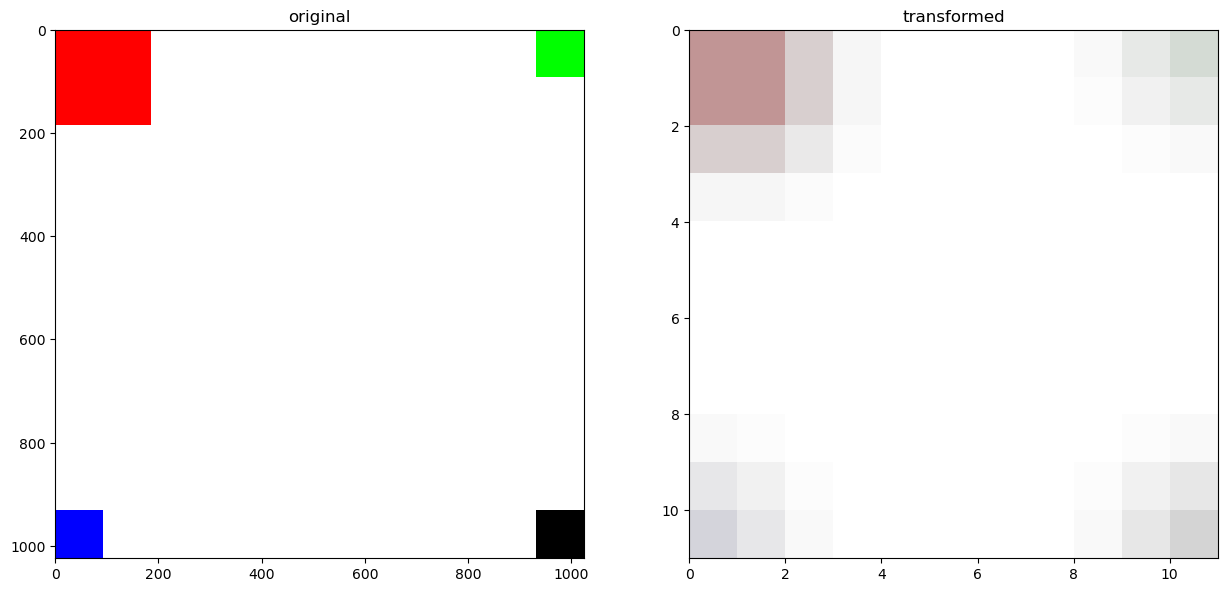

In [9]:
def stride_conv(img, kernel):
    # Compute the convolution as matrix-vector operation
    # 1. Construct a Topeliz matrix from the sliding window
    # 2. The convolution over the image is a matrix-vector multiplication for 
    #    each color dimension

    M, N, K = img.shape[0], img.shape[1], img.shape[2]
    E = kernel.shape[0]
    window_shape = kernel.shape + (K,)
    P = E // 2

    # pad the images
    img = np.pad(img, ((P, P), (P, P), (0, 0)), 'constant')

    # Convert the (W, H, K) -> (num_slice, kernel_size, K)
    # axis-0 is sliced and flattened window
    # axis-1 is the kernel-sized pixels
    S = (np.lib.stride_tricks
              .sliding_window_view(img, window_shape)
              .squeeze(axis=len(window_shape) - 1)
              .reshape(-1, np.prod(kernel.shape), K))
    # kernel = np.broadcast_to(kernel.reshape(np.prod(kernel.shape), 1), (np.prod(kernel.shape), K))
    kernel = kernel.reshape(np.prod(kernel.shape),)

    assert S.shape[0] == (M * N) # preserve the original dimension
    assert S.shape[1] == kernel.shape[0] # match kernel size

    # M*N, kernel_size, K @ kernel_size, K -> M*N, K
    result = np.zeros((M * N, K))
    for k in range(K):
        result[:, k] = S[:, :, k] @ kernel

    # NOTE: Fancy version using np.einsum
    # kernel = kernel.reshape(np.prod(kernel.shape), 1) # prepare for broadcasting
    # result = np.einsum('ijk,jk->ik', S, kernel)

    return result.reshape(M, N, K)

# Adding padding fix the dimension reduction issue
conv_and_plot(test_img, gk5, conv_fn=stride_conv)

In [10]:
import timeit
# Results are the same
np.allclose(stride_conv(test_img, gk5), pad_conv(test_img, gk5))

# Compare time difference, stride convolution is 10x faster
# The improvement comes from a few angles:
# - Vectorization instead of for-loops
[
    "pad_conv",
    timeit.timeit(lambda: pad_conv(test_img, gk5), number=1000),
    "stride_conv",
    timeit.timeit(lambda: stride_conv(test_img, gk5), number=1000),
]

['pad_conv', 2.9912200040052994, 'stride_conv', 0.18556581800658023]

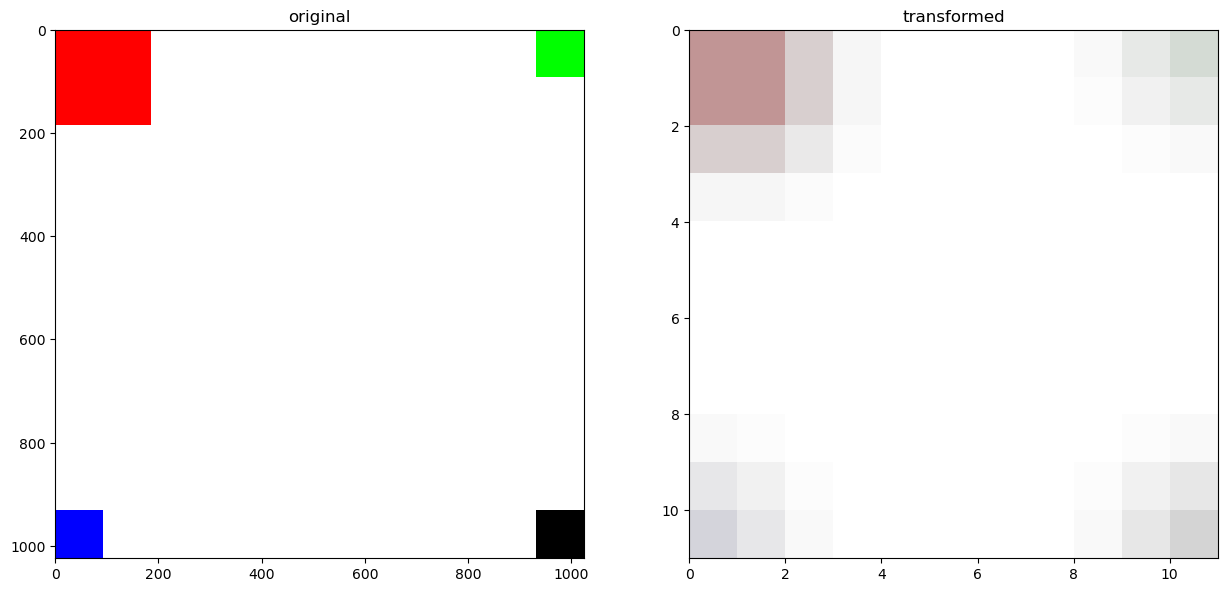

In [11]:
from scipy import signal

def scipy_conv(img, kernel):
    result = np.zeros_like(img)
    for k in range(img.shape[2]):
        result[:, :, k] = signal.correlate2d(img[:, :, k], kernel, mode='same')
    return result

conv_and_plot(test_img, gk5, conv_fn=scipy_conv)

In [12]:
[
    "stride_conv.test_img",
    timeit.timeit(lambda: stride_conv(test_img, gk5), number=1000),
    "scipy_conv.test_img",
    timeit.timeit(lambda: scipy_conv(test_img, gk5), number=1000),
    "stride_conv.img",
    timeit.timeit(lambda: stride_conv(img, gk5), number=10),
    "scipy_conv.img",
    timeit.timeit(lambda: scipy_conv(img, gk5), number=10),
]

['stride_conv.test_img',
 0.16822778299683705,
 'scipy_conv.test_img',
 0.05372669700591359,
 'stride_conv.img',
 5.657658794996678,
 'scipy_conv.img',
 3.0439249640039634]

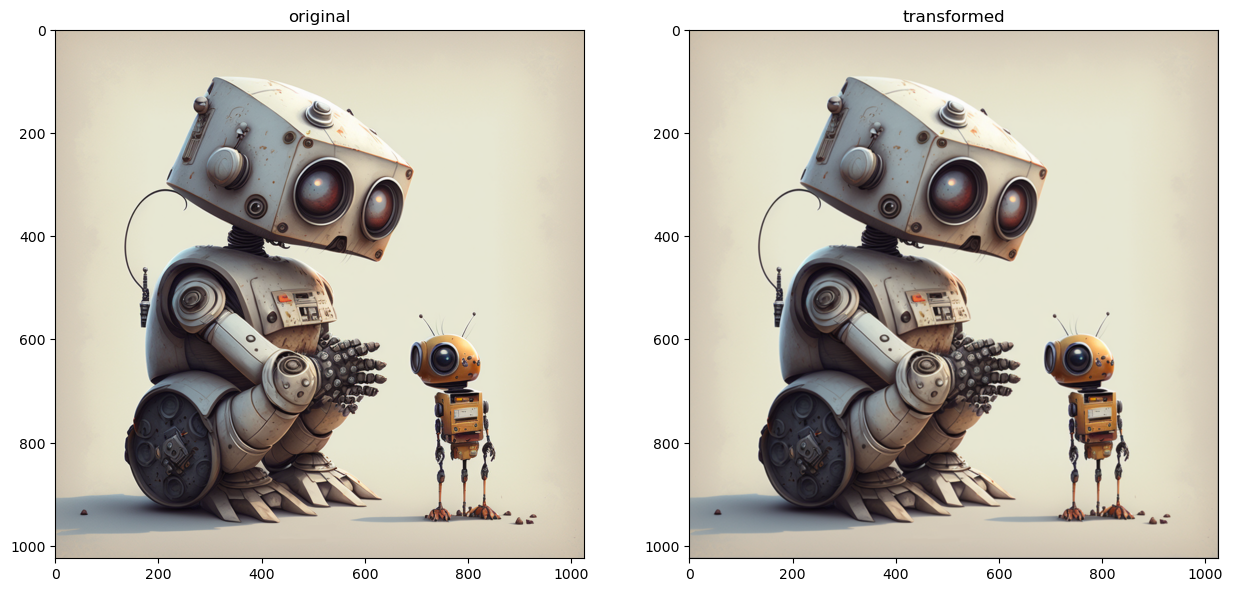

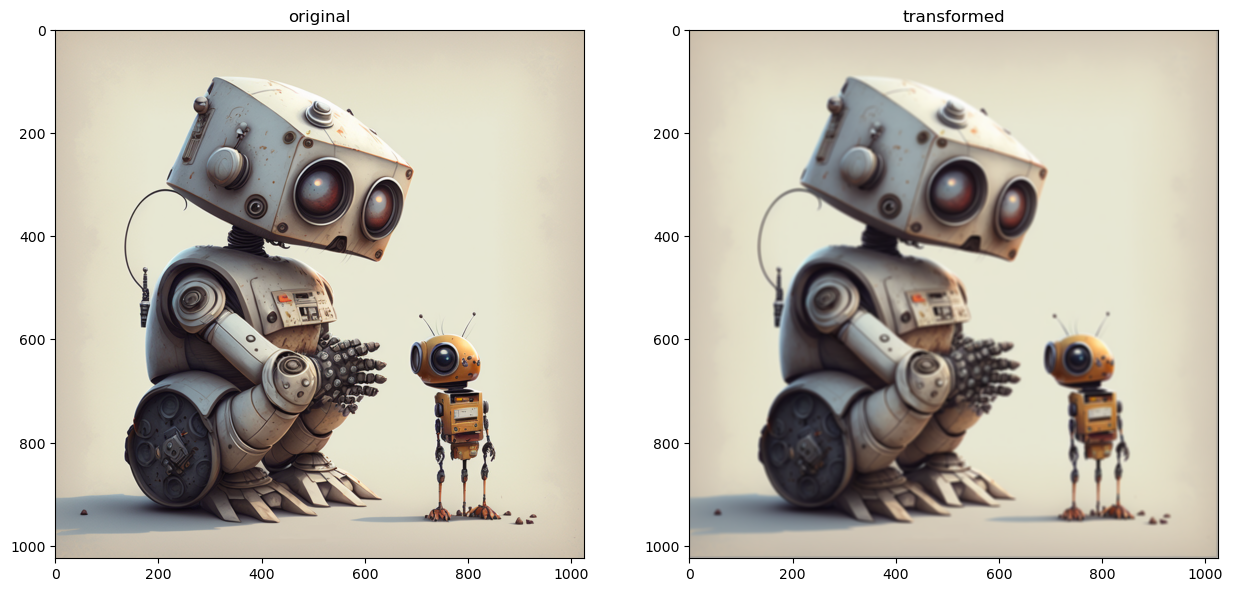

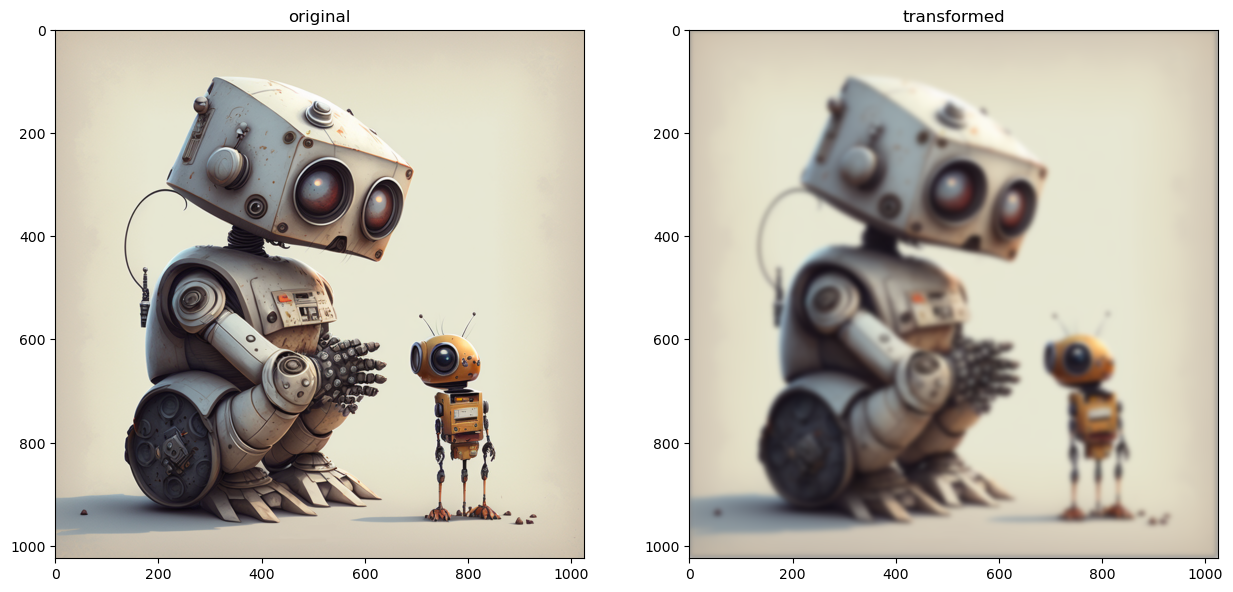

In [13]:
# Various gaussian kernels
for i in np.arange(1, 6, 2):
    s = 2 ** i
    gk = signal.windows.gaussian(s, std=i)
    gk = np.outer(gk, gk)
    gk = gk / gk.sum()
    conv_and_plot(img, gk, conv_fn=scipy_conv, figsize=(10, 10)) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


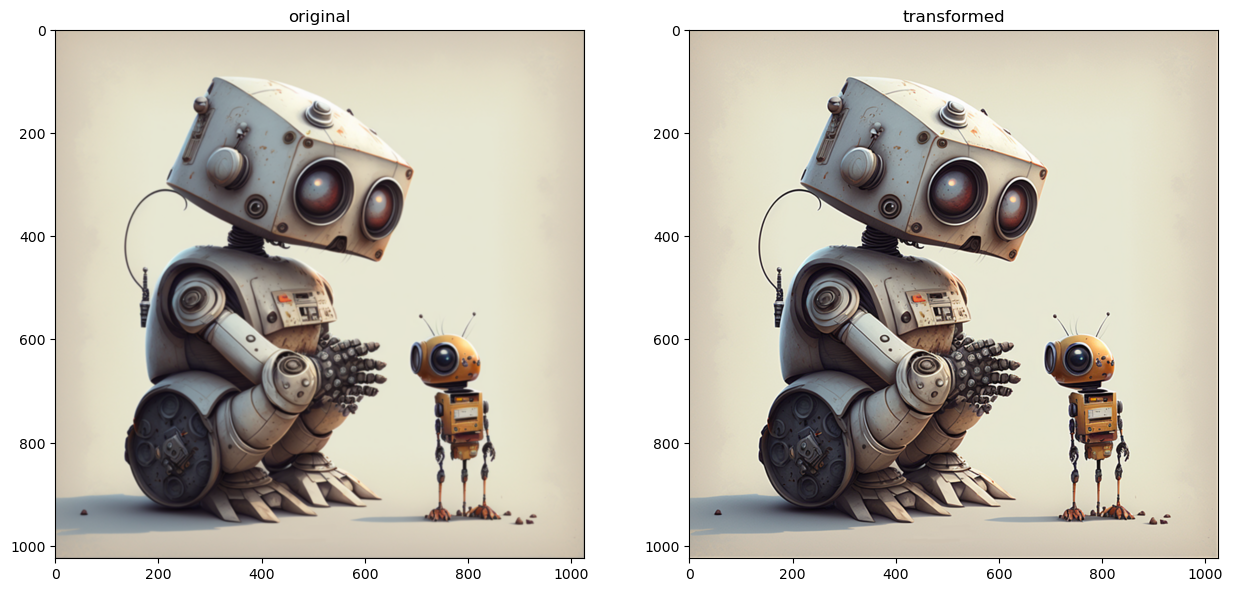

In [14]:
sharp_filter = np.array([[0, -1, 0],
                         [-1, 5, -1],
                         [0, -1, 0]])

bot = plt.imread('bot.png')
blurred = scipy_conv(bot, gk5)
conv_and_plot(blurred, sharp_filter, stride_conv, figsize=(15, 10))

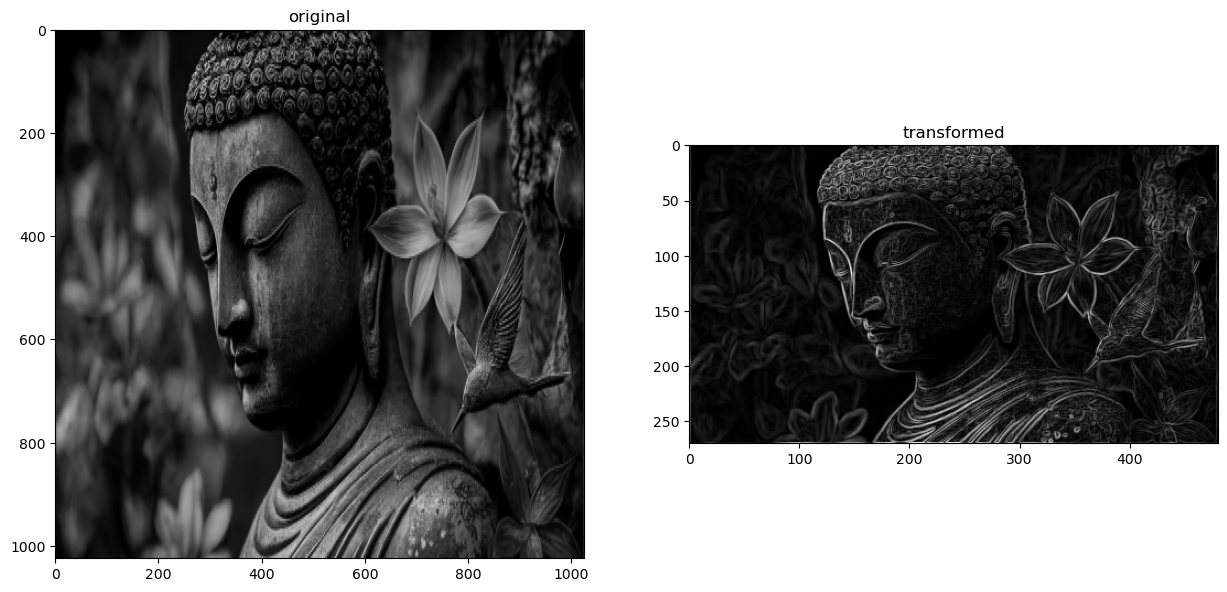

In [15]:
# Edge detections
prewitt_filter_x = np.array([[-1, 0, 1],
                             [-1, 0, 1],
                             [-1, 0, 1],
                             ])
prewitt_filter_y = np.array([[-1, -1, -1],
                             [0, 0, 0],
                             [1, 1, 1],
                             ])

sobel_filter_x = np.array([[-1, 0, 1],
                           [-2, 0, 2],
                           [-1, 0, 1]])
sobel_filter_y = np.array([[-1, -2, -1],
                           [0, 0, 0],
                           [1, 2, 1]])


def as_color(img):
    if len(img.shape) == 2:
        return np.stack([img, img, img], axis=2)
    else:
        return img

def prewitt_gradient(img):
    gx = stride_conv(img, prewitt_filter_x)
    gy = stride_conv(img, prewitt_filter_y)
    magnitude = np.sqrt(gx**2 + gy**2)

    # Normalize the image to the range [0, 255]
    magnitude = (magnitude / np.max(magnitude) * 255).astype(np.uint8)

    return magnitude


def sobel_gradient(img):
    gx = stride_conv(img, sobel_filter_x)
    gy = stride_conv(img, sobel_filter_y)
    magnitude = np.sqrt(gx**2 + gy**2)

    # Normalize the image to the range [0, 255]
    magnitude = (magnitude / np.max(magnitude) * 255).astype(np.uint8)

    return magnitude

def rgb2gray(rgb):
    if np.max(rgb) > 1.0:
        rgb = rgb / 255.0
    gray = np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
    # Always drop the alpha channel
    return np.stack((gray, gray, gray), axis=-1)

img_gray = rgb2gray(img)


bike = as_color(plt.imread('bike.jpg'))
bot = rgb2gray(plt.imread('bot.png'))
buddah = rgb2gray(plt.imread('buddha.webp'))

transform_and_plot(buddah, prewitt_gradient, figsize=(15, 10))

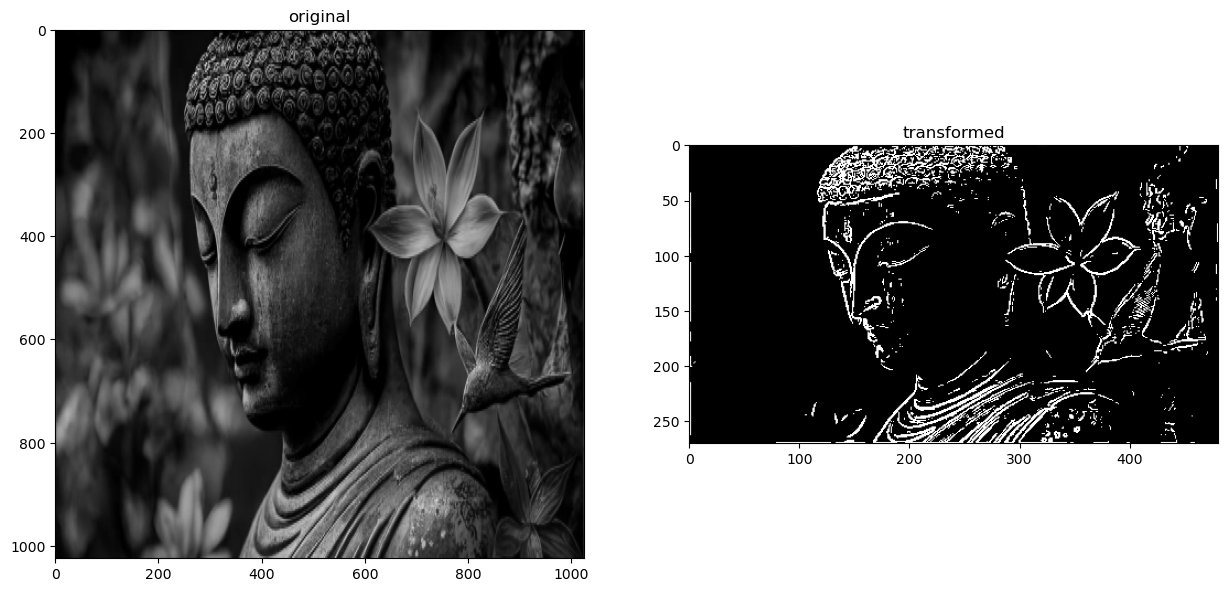

In [16]:
def compute_gradient_edges(img):
    gx = stride_conv(img, prewitt_filter_x)
    gy = stride_conv(img, prewitt_filter_y)

    # Compute gradient direction
    gradient_direction = np.arctan2(gy, gx)

    # Map to [0, 1] to match the hue range
    normalized_direction = (gradient_direction + np.pi) / (2 * np.pi)

    magnitude = np.sqrt(gx**2 + gy**2)

    # Normalize the image to the range [0, 255]
    magnitude = (magnitude / np.max(magnitude) * 255).astype(np.uint8)

    threshold = 64 
    magnitude[magnitude < threshold] = 0
    magnitude[magnitude >= threshold] = 255

    return magnitude

    # Create HSV image where hue corresponds to gradient direction
    # hsv = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.float32)
    # hsv[..., 0] = normalized_direction.mean(axis=2)
    # hsv[..., 1] = 1  # saturation
    # hsv[..., 2] = 1  # value/brightness
    # # Convert HSV to RGB
    # rgb = colors.hsv_to_rgb(hsv)

transform_and_plot(buddah, fn=compute_gradient_edges, figsize=(15, 10))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


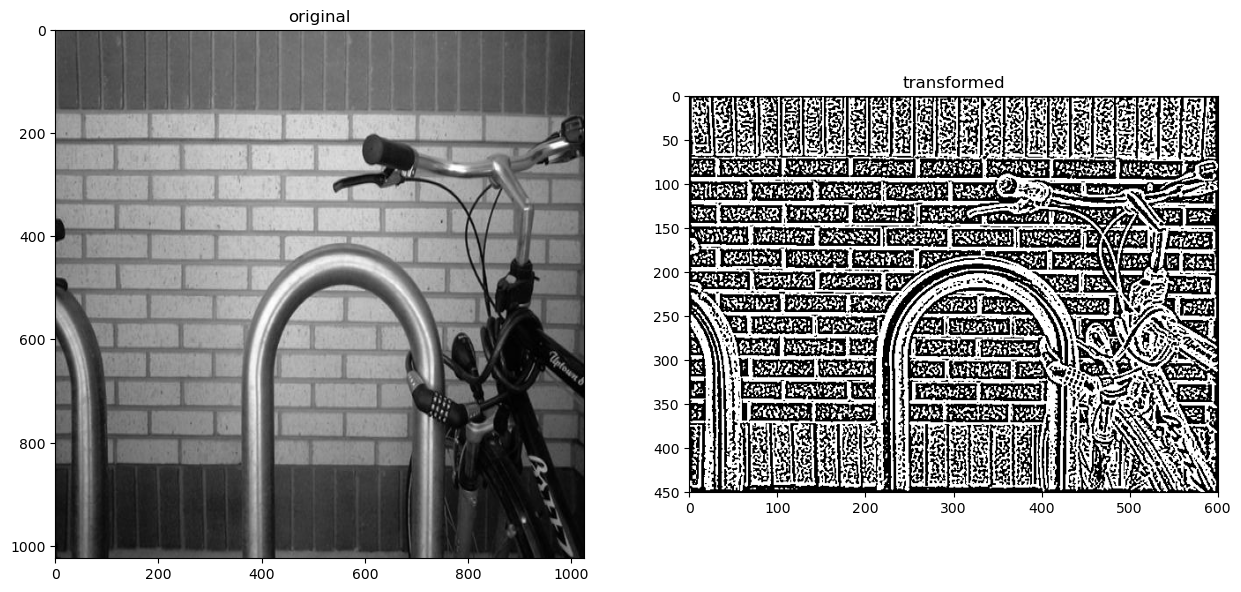

In [17]:
laplacian_filter = np.array([[0, 1, 0],
                             [1, -4, 1],
                             [0, 1, 0]])

# Often zero crossings are found in regions of very low gradient where the intensity gradient wobbles up and down around zero.
def LoG_filter(img):
    img = stride_conv(img, gk5) # apply gaussian smooth first to 
    laplacian = stride_conv(img, laplacian_filter)
    threshold = 0
    laplacian[laplacian < threshold] = 0
    laplacian[laplacian > threshold] = 255
    return laplacian

transform_and_plot(bike, LoG_filter, figsize=(15, 10))

# Section 2 - Feature Bank
With multiple filters capturing various features on an image, each perform convolution over the pixels image.
Could we compute them all at one pass?

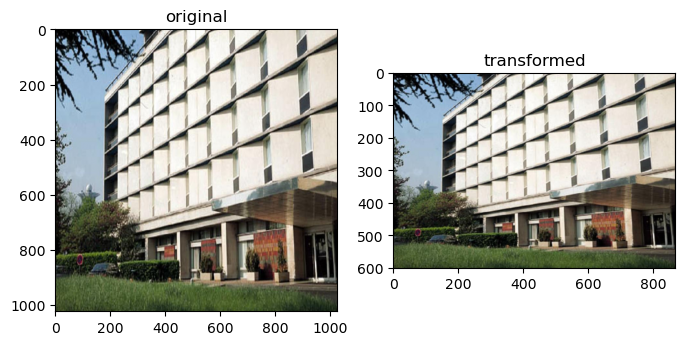

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


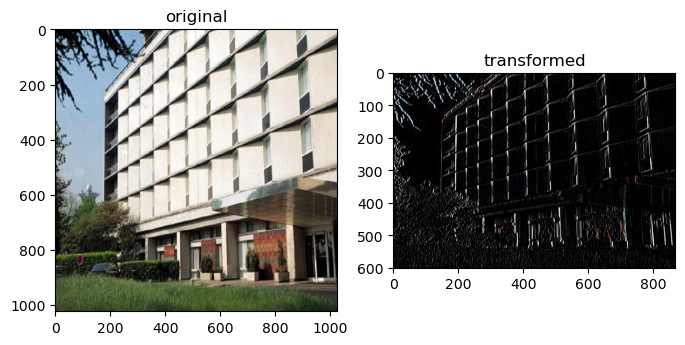

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


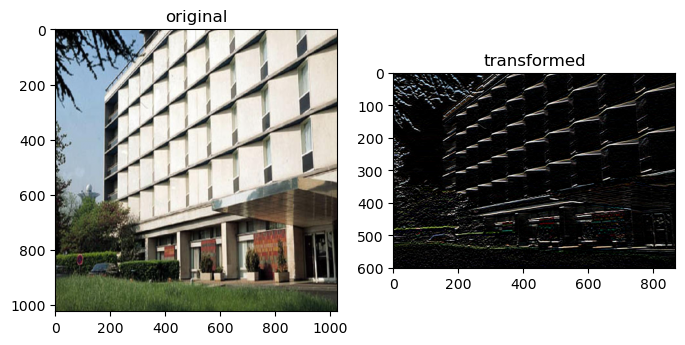

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


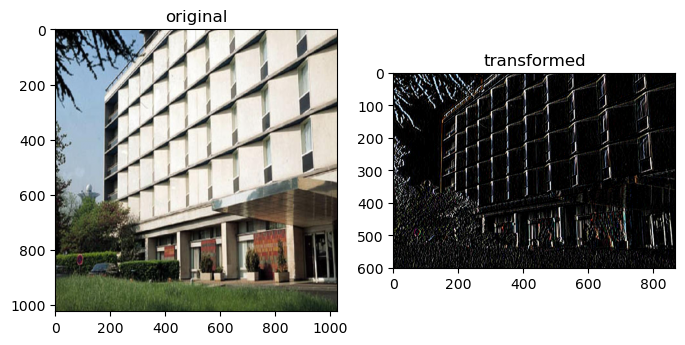

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


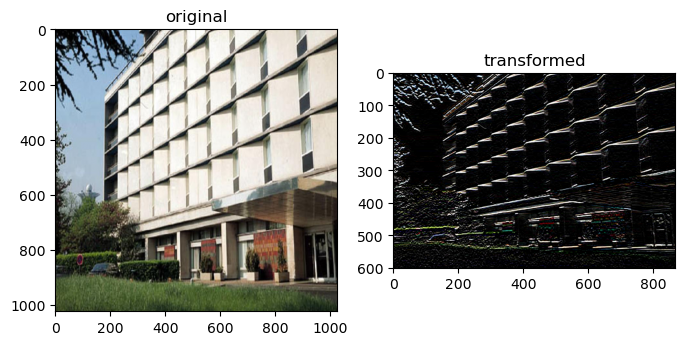

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


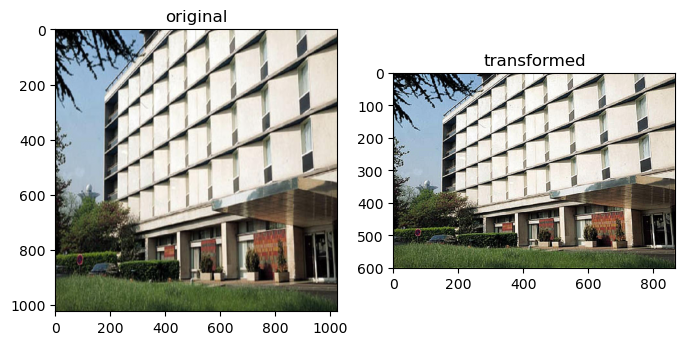

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


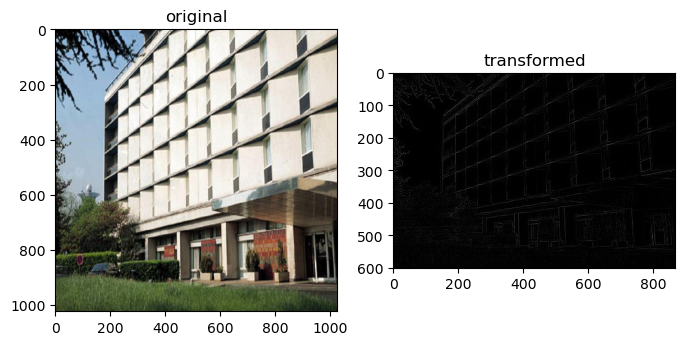

In [18]:
feature_bank = np.array([
    gk3,
    prewitt_filter_x,
    prewitt_filter_y,
    sobel_filter_x,
    sobel_filter_y,
    sharp_filter,
    laplacian_filter,
])

def feature_bank_conv(img, kernels):
    M, N, K = img.shape[0], img.shape[1], img.shape[2]
    assert all([kernels[0].shape == k.shape for k in kernels])
    assert kernels.shape[1] == kernels.shape[2] # square kernel
    F = kernels.shape[0] # number of kernels
    E = kernels.shape[1]
    kernel_shape = (E, E)

    window_shape = kernel_shape + (K,)
    P = E // 2

    # pad the images
    img = np.pad(img, ((P, P), (P, P), (0, 0)), 'constant')

    S = (np.lib.stride_tricks
              .sliding_window_view(img, window_shape)
              .squeeze(axis=len(window_shape) - 1)
              .reshape(-1, np.prod(kernel_shape), K))
    assert S.shape[0] == (M * N) # preserve the original dimension
    kernels = kernels.reshape(F, np.prod(kernel_shape)).swapaxes(0, 1)

    # NOTE: here we use matrix-matrix multiplication for multiple convolutions
    # M*N, kernel_size, K @ kernel_size, kernel_num, K -> M*N, kernel_num, K
    assert S.shape[1] == kernels.shape[0]
    result = np.zeros((M * N, F, K))
    for k in range(K):
        result[:, :, k] = S[:, :, k] @ kernels # Perform multiple kernel convolutions in one pass

    return result.swapaxes(0, 1).reshape(F, M, N, K)

building = plt.imread(fname='building.jpeg')
building = building / 255.0
features = feature_bank_conv(building, feature_bank)
for feature in features:
    plot_transformed(building, feature, figsize=(8, 8))